In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from tqdm import tqdm

In [2]:
from torch.utils.tensorboard import SummaryWriter

In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sambhav-chandra (metacognition). Use `wandb login --relogin` to force relogin


True

In [4]:
print(f"Pytorch Version: {torch.__version__}")
print(torch.__config__.show())

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Pytorch Version: 1.13.1
PyTorch built with:
  - C++ Version: 199711
  - MSVC 192829337
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_37,code=compute_37
  - CuDNN 8.5
  - Magma 2.5.4
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.7, CUDNN_VERSION=8.5.0, CXX_COMPILER=C:/cb/pytorch_1000000000000/work/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /GR /EHsc /w /bigob

In [5]:
#DATA = pathlib.Path("/media/sambhav/30AC4696AC46568E/datasets")
DATA = pathlib.Path.home() / "datasets"
train_dataset = datasets.FashionMNIST(
    root = DATA.as_posix(),
    #download = True,
    train = True,
    transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((.5, ), (.5,))])
)

test_dataset = datasets.FashionMNIST(
    root = DATA.as_posix(),
    train = False,
    transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((.5, ), (.5,))])
)

#train_dataset.data.to(DEVICE)
#train_dataset.targets.to(DEVICE)
#test_dataset.data.to(DEVICE)
#test_dataset.targets.to(DEVICE)

torch.Size([1, 28, 28])
cpu


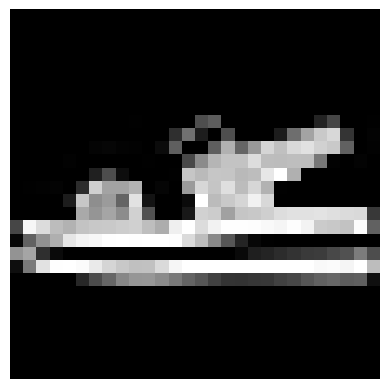

In [6]:
idx = torch.randint(1, len(train_dataset), (1,)).item()
img, label = train_dataset.__getitem__(idx)
plt.axis('off')
plt.imshow(img.squeeze(), cmap = 'gray')
print(img.shape)
print(img.device)

In [7]:
#HYPERPARAMETERS
class Config():
    def __init__(self, num_epochs, batch_size, learning_rate, loss_function, seed):
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.loss_function = loss_function
        self.seed = seed

        self.num_workers = 4
    
    def log_config(self):
        config_dictionary = {
            "num_epochs" : self.num_epochs,
            "batch_size" : self.batch_size,
            "learning_rate" : self.learning_rate,
            "loss_function": self.loss_function,
            "seed": self.seed
        }
        return config_dictionary

In [8]:
class TinyModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Flatten(start_dim = 1, end_dim = -1)
        self.linear1 = nn.Linear(28 * 28, 512)
        self.linear2 = nn.Linear(512, 10)
    
    def forward(self, x):
        x = self.input(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return x

In [9]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    num_batches = len(dataloader)
    epoch_loss = 0.0
    for batch_idx, (data, targets) in enumerate(tqdm(dataloader)):
        data, targets = data.to(DEVICE), targets.to(DEVICE)

        model.train()
        prediction = model(data) 

        loss = criterion(prediction, targets) 
        epoch_loss += loss.item() / num_batches

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Train Loss: {epoch_loss}")
    return epoch_loss

In [10]:
def test_one_epoch(model, dataloader, criterion):
    with torch.no_grad():

        num_batches = len(dataloader)
        epoch_loss = 0.0
        correct = 0

        model.eval()
        for batch_idx, (data, targets) in enumerate(tqdm(dataloader)):
            data, targets = data.to(DEVICE), targets.to(DEVICE)
            prediction = model(data)
            predicted_labels = prediction.argmax(1)

            loss = criterion(prediction, targets)
            epoch_loss += loss.item() / num_batches

            correct += (prediction.argmax(1) == targets).int().sum().item() / len(dataloader.dataset)
            accuracy = correct*100

        print(f"Test Loss: {epoch_loss}, Accuracy: {accuracy:>.2f}\n")
        return epoch_loss, accuracy

In [11]:
SEED = 69420
torch.manual_seed(SEED)

tinymodel = TinyModel().to(DEVICE)
criterion = nn.CrossEntropyLoss()

config = Config(25, 64, 3e-3, criterion._get_name(), SEED)

optimizer = torch.optim.Adam(tinymodel.parameters(), lr = config.learning_rate)

In [12]:
train_loader = DataLoader(
    dataset = train_dataset, 
    batch_size = config.batch_size, 
    shuffle = True, 
    num_workers = config.num_workers)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = config.batch_size,
    shuffle = True,
    num_workers = config.num_workers
)

In [ ]:
with wandb.init(project = "fashion-mnist", config = config.log_config()):
    for epoch in range(1, config.num_epochs + 1):

        wandb.watch(tinymodel, criterion, log = "all", log_freq=config.num_epochs)

        print(f"Epoch: {epoch}/{config.num_epochs}")
        train_loss = train_one_epoch(tinymodel, train_loader, criterion, optimizer)
        test_loss, accuracy = test_one_epoch(tinymodel, test_loader, criterion)

        wandb.log({"train/loss": train_loss, 
                "test/loss": test_loss, 
                "test/metric": accuracy})